# Module 1a: Seasonal Aggregation of WaPOR Data

**Last update: 21-Sept-2024**

[![Open in Colab](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORIPA/blob/main/Notebooks_beta/Module_1a_Seasonal_AETI_T_NPP.ipynb?target=\"_blank\")


### Introduction

This Notebook utilizes a script developed for the **WaPOR project** to perform the temporal aggregation of WaPOR data (AETI, T, and NPP). These aggregated datasets are essential for running the irrigation performance assessment module.

### Key Steps:

0. **Import Python Libraries**
1. **Import WaPOR Data**
2. **Define Function for Temporal Aggregation**
3. **Calculate Seasonal AETI, T, and NPP**
4. **Download the Zipped Seasonal Data (AETI, T, and NPP)**

### Input Data:

To run this Notebook, we use AETI, T, and NPP data. These datasets can either be:
- Downloaded using the [Download_WaPORv3_Data Notebook](https://github.com/wateraccounting/WaPORMOOC/blob/main/1_WaPOR_download_colab/Download_WaPORv3_Data.ipynb)
- Generated using **PyWaPOR**

### Required Data for This Notebook:

2. **Data Types**: AETI, T, and NPP
3. **Spatial Resolution**: Level 3
4. **Temporal Resolution**: Dekadal (~10-day intervals)
5. **Season Start Date**: SOS (Start of a season)
6. **Season End Date**:  EOS (End of a season)

### Function:
The function **SumSeason** used in this Notebook is derived from [WaPORWP](https://github.com/wateraccounting/WAPORWP), originally developed by Abebe Chukalla and licensed under **CC BY 4.0 Creative Commons**.

---

© 2024 IHE Delft. Licensed under **CC BY-SA Creative Commons**.


---

## Step 0. Import modules/libraries

In [4]:
!pip install rioxarray --quiet

In [32]:
!pip install gdal

In [8]:
import os                                 # a module for interacting with the operating system (e.g., file manipulation, directory management)
import sys                                # provides access to system-specific parameters and functions (e.g., modifying the Python path)
import glob                               # used to retrieve files/pathnames matching a specified pattern (e.g., searching for files with a specific extension)
import re                                 # regular expression module, used for searching, matching, and replacing text patterns
import rioxarray as rio                   # extends xarray to support geospatial raster data (e.g., reading, writing, and analyzing raster data with CRS info)
import pandas as pd                       # used for data manipulation and analysis, providing data structures like DataFrames for tabular data
import numpy as np                        # stands for 'Numerical Python', used for numerical computations with arrays and matrices, and mathematical operations
import calendar                           # provides functions related to calendar operations (e.g., retrieving month names, leap year checks)
import datetime                           # module for working with dates and times (e.g., manipulating, formatting, or calculating time durations)
from osgeo import gdal                    # Geospatial Data Abstraction Library, used for reading, writing, and processing geospatial raster formats (e.g., GeoTIFF)
from matplotlib import pyplot as plt      # plotting library used for creating 2D graphs and visualizations, such as line charts, histograms, and scatter plots

### Upload or Mount Data

Upload your data or mount the data from your Google Drive if it has been downloaded from a server (e.g., using the Download_WaPORv3_Data Notebook).

Data generated using PyWaPOR are in NetCDF format and need to be converted to TIFF format for further processing.

Make sure to update file paths as needed to point to the correct folder.

In [9]:
# Upload data.
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!unzip '/content/data.zip' -d '/content'

Archive:  /content/data.zip
   creating: /content/content/output/
   creating: /content/content/output/L3-NPP-D/
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023-02-11.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-11-21.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023-01-21.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-12-01.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-11-11.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-11-01.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023-04-21.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2022-10-01.tif  
  inflating: /content/content/output/L3-NPP-D/bb.GEZ_L3-NPP-D_NONE_dekad_converted_2023

## Step 1. Import raster (WaPOR) data

In this section, you will import the WaPOR data (AETI, T, and NPP). First, you need to define the file paths to locate the WaPORv3 data.


The code below identifies the working directory, sets the location of the WaPOR data, and retrieves the list of files (in `.tif` format) for each dataset (AETI, Transpiration, and NPP).

In [13]:
# Define project directory and the location of WaPOR data
dir_proj = os.path.split(os.getcwd())[0]
dir_data = "/content/content/output/"

# Define and retrieve input files for AETI, T, and NPP data
input_folderAETI = os.path.join(dir_proj, dir_data, "L3-AETI-D")
input_fhsAETI = glob.glob(os.path.join(input_folderAETI, '*.tif'))

input_folderT = os.path.join(dir_proj, dir_data, "L3-T-D")
input_fhsT = glob.glob(os.path.join(input_folderT, '*.tif'))

input_folderNPP = os.path.join(dir_proj, dir_data, "L3-NPP-D")
input_fhsNPP = glob.glob(os.path.join(input_folderNPP, '*.tif'))

<div class="alert alert-warning">

**NOTE:** Before continuing with the next steps, make sure that you already have the data needed in the folders below.

</div>

In [12]:
print('Folder of input AETI data: '+input_folderAETI)
print('Folder of input T data: '+input_folderT)
print('Folder of input NPP data: '+input_folderNPP)

Folder of input AETI data: /content/content/output/L3-AETI-D
Folder of input T data: /content/content/output/L3-T-D
Folder of input NPP data: /content/content/output/L3-NPP-D


This script defines (and create) the output folder (same folder for all seasonal files).

In [16]:
# Define the project directory and output folder path
dir_proj = os.path.split(os.getcwd())[0]  # Get the parent directory of the current working directory
dir_data = r"/content/output_M1a/"          # Specify the directory where the output will be stored

# Create output folders for storing seasonal data
output_folderT    = os.path.join(dir_proj, dir_data, "T_season")     # Folder for seasonal Transpiration (T) data
output_folderAETI = os.path.join(dir_proj, dir_data, "AETI_season")  # Folder for seasonal AETI data
output_folderNPP  = os.path.join(dir_proj, dir_data, "NPP_season")   # Folder for seasonal NPP data

# Check if the output folders exist, if not, create them
for folder in [output_folderT, output_folderAETI, output_folderNPP]:
    if not os.path.exists(folder):
        os.makedirs(folder)

## Step 2. Define function for temporal aggregation

This script defines the `SumSeason` function, which will be used in the following sections to aggregate seasonal data such as AETI, T and NPP.

© 2020 Abebe Chukalla. Licensed under CC BY 4.0 Creative Commons.

In [19]:
# Function to sum raster values between two specified dates (sowing and harvesting)
def SumSeason(input_fhs, sowing_date, harvesting_date):
    """
    This function sums the raster data (e.g., AETI, T, NPP) that fall within the provided sowing and harvesting dates.

    Parameters:
    - input_fhs: List of file paths to the input raster files
    - sowing_date: The starting date of the season (as a datetime.date object)
    - harvesting_date: The ending date of the season (as a datetime.date object)

    Returns:
    - Sums: Aggregated raster data for the specified period
    """

    # Initialize the cumulative sum variable for raster data
    Sums = 0

    # Loop through each raster file
    for i, in_fh in enumerate(input_fhs):
        # Open the raster file and mask out invalid data using the fill value from the attributes
        ds = rio.open_rasterio(in_fh)
        ds = ds.where(ds != ds.attrs['_FillValue'])  # Ignore fill values in the raster data

        # Save the attributes of the first raster for later use (metadata such as start/end dates)
        if i == 0:
            attrs = ds.attrs

        # Extract the start and end dates of the raster from its attributes
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d').date()
        raster_enddate = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d').date()

        # Case 1: The entire raster period is within the sowing and harvesting dates
        if (raster_startdate >= sowing_date) and (raster_enddate <= harvesting_date):
            Sum = ds  # Use the full raster data
            Sums += Sum  # Accumulate it into the total sum

        # Case 2: Raster starts before sowing but ends within the growing season
        elif (raster_startdate < sowing_date) and (raster_enddate > sowing_date) and (raster_enddate < harvesting_date):
            # Add the fraction of the raster data that overlaps with the sowing date
            Sum = ds * ((raster_enddate - sowing_date) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

        # Case 3: Raster starts within the growing season but ends after the harvesting date
        elif (raster_startdate > sowing_date) and (raster_startdate < harvesting_date) and (raster_enddate > harvesting_date):
            # Add the fraction of the raster data that overlaps with the harvesting date
            Sum = ds * ((harvesting_date - raster_startdate) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

        # Case 4: Sowing and harvesting dates are both within the raster period
        elif (sowing_date >= raster_startdate) and (harvesting_date <= raster_enddate):
            # Add the fraction of the raster data that overlaps with both the sowing and harvesting dates
            Sum = ds * ((harvesting_date - sowing_date) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

    # Update the raster attributes with new seasonal start and end dates
    attrs.update({
        'start_date': datetime.datetime.strftime(SOS, '%Y-%m-%d'),  # Seasonal start date
        'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),    # Seasonal end date
        'units': 'mm/season'  # Update units to reflect seasonal aggregation
    })

    # Remove unnecessary attributes to clean up the metadata
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    # Assign the updated attributes to the summed raster
    Sums.attrs = attrs

    # Return the final aggregated raster data
    return Sums


## Step 3. Calculate seasonal AETI, T and NPP

### Define seasons

Here the start (SOS) and end (EOS) dates for each season are defined.

In [20]:
season_periods = {
    'season1': {'SOS': '2022-10-01', 'EOS': '2023-04-30'}
}

## i) Calculate Seasonal Actual Evapotranspiration and Interception (AETI)

In this section, the start and end dates for each season are defined and the `SumSeason` function is used to aggregate AETI data. The aggregated data is saved, and the mean and standard deviation (SD) are calculated for each season. Finally, the seasonal AETI data is visualized through raster maps.

the mean, SD for  2022-10-01/2023-04-30 = 536.7 & 246.6


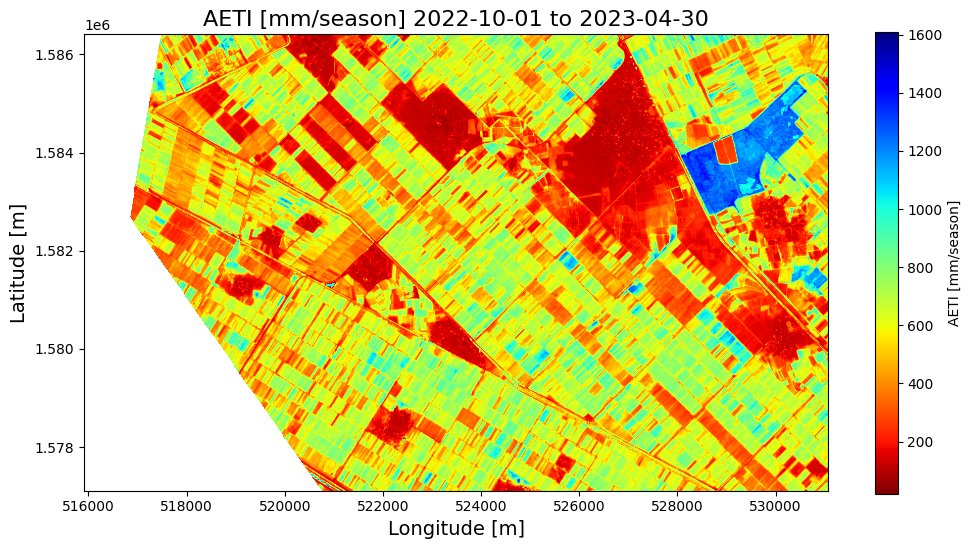

In [24]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsAETI
output_folder  = output_folderAETI


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in the output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'AETI' + '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='AETI [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('AETI [mm/season] ' + season_periods[season]['SOS'] + ' to ' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ()

## ii) Calculate seasonal Transpiration (T)



the mean, SD for  2022-10-01/2023-04-30 = 373.6 & 219.4


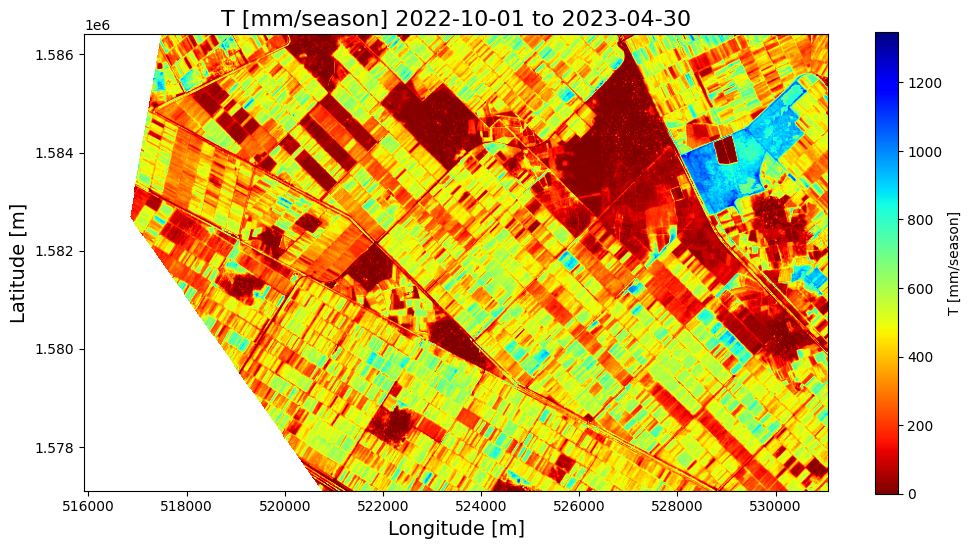

In [26]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsT
output_folder  = output_folderT


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'T' + '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='T [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('T [mm/season] ' + season_periods[season]['SOS'] + ' to ' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ()

## iiI) Calculate seasonal Net Primary Production (NPP)

the mean, SD for  2022-10-01/2023-04-30 = 165.3 & 98.0


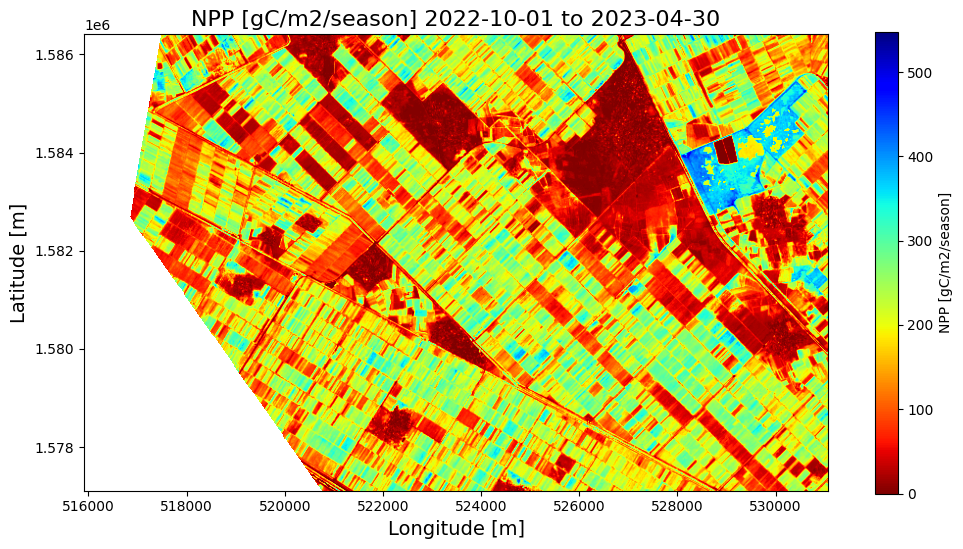

In [27]:
# Assign inputs to the SumSeason function
input_fhs      = input_fhsNPP
output_folder  = output_folderNPP


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'NPP' + '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='NPP [gC/m2/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('NPP [gC/m2/season] ' + season_periods[season]['SOS'] + ' to ' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ()


## Zip and download seasonal data

In [30]:
# Zip the entire contents of the /content/output_M1a/ directory into a file named WaPORv3_M1_Seasonal.zip
!zip -r /content/WaPORv3_M1_Seasonal.zip /content/output_M1a/

# Import the necessary module to download the zip file
from google.colab import files

# Download the zipped file (WaPORv3_M1_Seasonal.zip) to your local machine
files.download('/content/WaPORv3_M1_Seasonal.zip')

updating: content/output_M1a/AETI_season/ (stored 0%)
updating: content/output_M1a/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif (deflated 69%)
updating: content/output_M1a/NPP_season/ (stored 0%)
updating: content/output_M1a/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif (deflated 58%)
updating: content/output_M1a/T_season/ (stored 0%)
updating: content/output_M1a/T_season/T_season1_2022-10-01_to_2023-04-30.tif (deflated 69%)
updating: content/output_M1a/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# If you want to delete all files and folders inside the /content/content/output/ directory
# !rm -r /content/content/output/*

# If you want to delete the entire /content/content/output/ directory itself, including its contents, use the following command:
# !rm -r /content/content/output/